In [1]:
import nrrd
import os
import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import csv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model

In [2]:
data_path = 'F:\\Birva_Harsh\\NEW_KNEE_CT_100_V1\\Train'

In [3]:
hip_paths = []
mask_paths = []
csv_paths = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.nrrd'):
            if 'segmentation' in file.lower():
                mask_path = os.path.join(folder_path, file)
                mask_paths.append(mask_path)
            else:
                hip_path = os.path.join(folder_path, file)
                hip_paths.append(hip_path)
                
        if file == 'LM_INFO_voxel_Coord_femur.csv':
            csv_path = os.path.join(folder_path, file)
            csv_paths.append(csv_path)

In [4]:
df_train = pd.DataFrame({'hip': hip_paths, 'mask': mask_paths})

In [5]:
data_path = 'F:\\Birva_Harsh\\NEW_KNEE_CT_100_V1\\Test'

In [6]:
hip_paths = []
mask_paths = []
csv_paths_test = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    for file in os.listdir(folder_path):
        if file.endswith('.nrrd'):
            if 'segmentation' in file.lower():
                mask_path = os.path.join(folder_path, file)
                mask_paths.append(mask_path)
            else:
                hip_path = os.path.join(folder_path, file)
                hip_paths.append(hip_path)
                
        if file == 'LM_INFO_voxel_Coord_femur.csv':
            csv_path = os.path.join(folder_path, file)
            csv_paths_test.append(csv_path)

In [7]:
df_test = pd.DataFrame({'hip': hip_paths, 'mask': mask_paths})

In [8]:
def read_csv_to_dict_LM_INFO(csv_file):
    LM_INFO = {}
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)       
        for rows in reader:
            LM_INFO[rows[0]] = np.asarray([float(rows[1]), float(rows[2]), float(rows[3])])
            #print(rows[0], ':', float(rows[1]), float(rows[2]), float(rows[3]))
            
    return LM_INFO

In [9]:
def zoom_1mm(img,original_space,new_space=[1.0,1.0,1.0]):
    zoom_factor = [original_space[i] / new_space[i] for i in range(3)]
    zoomed_image = zoom(img, zoom_factor, order=0)
    
    return zoomed_image

In [10]:
def hip_centre(path, original_space):
    HC = read_csv_to_dict_LM_INFO(path)['FHP']
    HC_1mm = [round(original_space[i] * HC[i]) for i in range(3)]
    
    return HC_1mm

In [11]:
def padding(img, target_size=(512, 512)):
    current_size = img.shape
    pad_height = target_size[0] - current_size[0]
    pad_width = target_size[1] - current_size[1]

    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    padded_img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='minimum')
    
    return padded_img,pad_left,pad_top

# Train Data

In [12]:
centre_slices = []
centre_probs = []
original_HC = []
padding_HC = []

non_centre_slices = []
non_centre_probs = []
non_original_HC = []
non_padding_HC = []

for i in range(len(df_train)):
    img, kinfo = nrrd.read(df_train.loc[i,'hip'])
    mask, minfo = nrrd.read(df_train.loc[i,'mask'])

    spc_dir = np.diag(kinfo['space directions'])
    
    img_1mm = zoom_1mm(img, spc_dir)
    mask_1mm = zoom_1mm(mask, spc_dir)
    
    HC = hip_centre(csv_paths[i], spc_dir)
    original_HC.append(HC)

    for j in range(-5,6):
        axial = HC[2] + j
        img,left,top = padding(img_1mm[:,:,axial])
        
        centre_slices.append(img)
        centre_probs.append(1 - abs(j)*0.12)
        padding_HC.append([HC[0]+left,HC[1]+top])

    limit = HC[2] - 20
    
    random = np.random.randint(20, limit, size=10)
                               
    for j in range(10):
        img,left,top = padding(img_1mm[:,:,random[j]])
        non_centre_slices.append(img)
        non_centre_probs.append(0)
        non_padding_HC.append([HC[0]+left,HC[1]+top])
        
    print(img_1mm.shape)

(482, 482, 908)
(430, 430, 916)
(430, 430, 956)
(430, 430, 811)
(430, 430, 936)
(430, 430, 833)
(430, 430, 995)
(430, 430, 890)
(430, 430, 802)
(430, 430, 832)
(500, 500, 844)
(430, 430, 847)
(430, 430, 862)
(430, 430, 837)
(430, 430, 863)
(414, 414, 833)
(407, 407, 797)
(430, 430, 847)
(430, 430, 790)
(430, 430, 947)
(430, 430, 949)
(430, 430, 841)
(430, 430, 888)
(430, 430, 875)
(430, 430, 893)
(430, 430, 891)
(430, 430, 862)
(430, 430, 816)
(430, 430, 905)
(452, 452, 927)
(430, 430, 870)
(430, 430, 969)
(430, 430, 956)
(430, 430, 821)
(430, 430, 864)
(430, 430, 831)
(400, 400, 752)
(433, 433, 876)
(430, 430, 838)
(400, 400, 874)
(424, 424, 944)
(424, 424, 976)
(430, 430, 885)
(430, 430, 987)
(430, 430, 900)
(430, 430, 808)
(430, 430, 837)
(345, 345, 890)
(430, 430, 789)
(430, 430, 832)
(430, 430, 860)
(430, 430, 840)
(430, 430, 968)
(428, 428, 862)
(430, 430, 984)
(435, 435, 925)
(435, 435, 956)
(430, 430, 879)
(430, 430, 911)
(430, 430, 925)
(430, 430, 846)
(430, 430, 862)
(430, 43

In [13]:
centre_slices[0].shape

(512, 512)

In [14]:
centre_probs

[0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0,
 0.88,
 0.76,
 0.64,
 0.52,
 0.4,
 0.4,
 0.52,
 0.64,
 0.76,
 0.88,
 1.0

In [15]:
non_centre_slices[0].shape

(512, 512)

In [16]:
non_centre_probs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [17]:
HC

[290, 212, 855]

In [18]:
padding_HC[0][0]

297

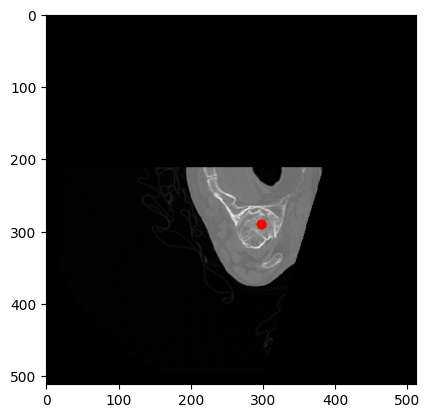

In [19]:
plt.imshow(centre_slices[0],cmap='gray')
plt.scatter([padding_HC[0][0]], [padding_HC[0][1]], c='red', s=40) 
plt.show()

# Test Data

In [20]:
centre_slices_test = []
centre_probs_test = []
original_HC_test = []
padding_HC_test = []

non_centre_slices_test = []
non_centre_probs_test = []
non_original_HC_test = []
non_padding_HC_test = []

for i in range(len(df_test)):
    img, kinfo = nrrd.read(df_test.loc[i,'hip'])
    mask, minfo = nrrd.read(df_test.loc[i,'mask'])

    spc_dir = np.diag(kinfo['space directions'])
    
    img_1mm = zoom_1mm(img, spc_dir)
    mask_1mm = zoom_1mm(mask, spc_dir)
    
    HC = hip_centre(csv_paths_test[i], spc_dir)
    original_HC_test.append(HC)

    for j in range(-5,6):
        axial = HC[2] + j
        img,left,top = padding(img_1mm[:,:,axial])
        
        centre_slices_test.append(img)
        centre_probs_test.append(1 - abs(j)*0.12)
        padding_HC_test.append([HC[0]+left,HC[1]+top])

    limit = HC[2] - 20
    
    random = np.random.randint(20, limit, size=10)
                               
    for j in range(10):
        img,left,top = padding(img_1mm[:,:,random[j]])
        non_centre_slices_test.append(img)
        non_centre_probs_test.append(0)
        non_padding_HC_test.append([HC[0]+left,HC[1]+top])
        
    print(img_1mm.shape)

(430, 430, 792)
(500, 500, 945)
(430, 430, 881)
(400, 400, 856)
(400, 400, 867)
(430, 430, 896)
(430, 430, 819)
(500, 500, 817)
(430, 430, 840)
(430, 430, 922)
(430, 430, 871)
(430, 430, 832)
(430, 430, 832)
(430, 430, 822)
(430, 430, 829)
(430, 430, 996)
(400, 400, 908)
(400, 400, 895)
(430, 430, 833)
(430, 430, 935)
